<a href="https://colab.research.google.com/github/rauf547/IDS-Trabalho-Final/blob/main/Trabalho_Final_Engenharia_de_Sistemas_de_Detec%C3%A7%C3%A3o_de_Intrus%C3%B5es_NOVO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1: Montar o Google Drive no Colab

In [2]:
from google.colab import drive

# Monta o Google Drive no diretório '/content/drive'
drive.mount('/content/drive')

Mounted at /content/drive


# 2: Carregar os Dados do Dataset

In [3]:
import pandas as pd

# Define o caminho base
CAMINHO_BASE = '/content/drive/MyDrive/Mestrado/IDS_Dataset/'

# 1. Carregar o conjunto de treinamento
df_treino = pd.read_csv(CAMINHO_BASE + 'UNSW_NB15_training-set.csv')

# 2. Carregar o conjunto de teste
df_teste = pd.read_csv(CAMINHO_BASE + 'UNSW_NB15_testing-set.csv')

# Exibe as primeiras linhas para verificar se o carregamento foi bem-sucedido
print("--- DataFrame de Treinamento (Primeiras 5 linhas) ---")
print(df_treino.head())
print("\n--- DataFrame de Teste (Informações básicas) ---")
df_teste.info()

--- DataFrame de Treinamento (Primeiras 5 linhas) ---
   id       dur proto service state  spkts  dpkts  sbytes  dbytes       rate  \
0   1  0.121478   tcp       -   FIN      6      4     258     172  74.087490   
1   2  0.649902   tcp       -   FIN     14     38     734   42014  78.473372   
2   3  1.623129   tcp       -   FIN      8     16     364   13186  14.170161   
3   4  1.681642   tcp     ftp   FIN     12     12     628     770  13.677108   
4   5  0.449454   tcp       -   FIN     10      6     534     268  33.373826   

   ...  ct_dst_sport_ltm  ct_dst_src_ltm  is_ftp_login  ct_ftp_cmd  \
0  ...                 1               1             0           0   
1  ...                 1               2             0           0   
2  ...                 1               3             0           0   
3  ...                 1               3             1           1   
4  ...                 1              40             0           0   

   ct_flw_http_mthd  ct_src_ltm  ct_srv_dst 

# 3:  Pré-processamento

> - Verificação de Dimensões
> - Verificação de Valores Nulos
> - Distribuição da Variável Alvo

In [4]:
# Verificação de Dimensões
print(f"Shape do Treinamento: {df_treino.shape}")
print(f"Shape do Teste: {df_teste.shape}")

# Verificação de Valores Nulos
print("\nValores Nulos no Treinamento:")
print(df_treino.isnull().sum().sort_values(ascending=False).head(5))

# Distribuição da Variável Alvo (Label binária: 0=Normal, 1=Ataque)
print("\nDistribuição da Label (Treinamento):")
print(df_treino['label'].value_counts())

Shape do Treinamento: (175341, 45)
Shape do Teste: (82332, 45)

Valores Nulos no Treinamento:
id         0
dur        0
proto      0
service    0
state      0
dtype: int64

Distribuição da Label (Treinamento):
label
1    119341
0     56000
Name: count, dtype: int64


> -  Remoção da Coluna 'id' e Separação das Variáveis Alvo

In [5]:
# Drop da coluna 'id' em ambos os conjuntos
df_treino = df_treino.drop('id', axis=1)
df_teste = df_teste.drop('id', axis=1)

# Separando Features (X) e Variável Alvo (y) para o conjunto de TREINAMENTO
# Variável alvo binária (y_train, y_test) e Features (X_train, X_test)
X_treino = df_treino.drop(['label', 'attack_cat'], axis=1) # X contém todas as features
y_treino = df_treino['label']  # y_treino contém apenas a label binária
# Separando Features (X) e Variável Alvo (y) para o conjunto de TESTE
X_teste = df_teste.drop(['label', 'attack_cat'], axis=1)
y_teste = df_teste['label']

print(f"\nShape de X_treino (Features): {X_treino.shape}")


Shape de X_treino (Features): (175341, 42)


> *   Identificar e Codificar Variáveis Categóricas








In [6]:
import pandas as pd # Importação necessária para o get_dummies e manipulação de DataFrames

# 1. Identificar as colunas categóricas (object)
# As features categóricas no UNSW-NB15 são 'proto', 'service' e 'state'
colunas_categoricas = X_treino.select_dtypes(include=['object']).columns

# 2. Aplicar One-Hot Encoding em Treino e Teste
print("Aplicando One-Hot Encoding...")
X_treino_encoded = pd.get_dummies(X_treino, columns=colunas_categoricas, drop_first=True)
X_teste_encoded = pd.get_dummies(X_teste, columns=colunas_categoricas, drop_first=True)


# 3. Passo CRÍTICO: Alinhamento das colunas (Necessário para a consistência)
#    E DEFINIÇÃO DA VARIÁVEL 'train_cols'
# ----------------------------------------------------------------------------------

# Coleta todas as colunas de X_treino_encoded (INCLUI as novas colunas OHE)
train_cols = X_treino_encoded.columns

# Adiciona colunas faltantes em X_teste_encoded (preenchendo com 0s)
# Isso lida com categorias que estão no treino, mas não no teste
X_teste_encoded = X_teste_encoded.reindex(columns=train_cols, fill_value=0)

# Reindexar o treino (garante que X_treino e X_teste tenham exatamente a mesma ordem de colunas)
X_treino_encoded = X_treino_encoded.reindex(columns=train_cols, fill_value=0)


print("\nOne-Hot Encoding e Alinhamento de colunas concluídos.")
print(f"Shape de X_treino_encoded após OHE: {X_treino_encoded.shape}")
print(f"Shape de X_teste_encoded após OHE: {X_teste_encoded.shape}")
print(f"Número de features: {len(train_cols)}")

Aplicando One-Hot Encoding...

One-Hot Encoding e Alinhamento de colunas concluídos.
Shape de X_treino_encoded após OHE: (175341, 191)
Shape de X_teste_encoded após OHE: (82332, 191)
Número de features: 191


>*   Normalização das features numéricas





In [7]:
from sklearn.preprocessing import StandardScaler

# 1. Instanciar o escalonador
scaler = StandardScaler()

# 2. Fazer o FIT (aprender média e desvio padrão) APENAS no conjunto de TREINAMENTO
X_treino_scaled = scaler.fit_transform(X_treino_encoded)

# 3. Aplicar o TRANSFORM (usar a média e desvio padrão aprendidos no treino)
#    ao conjunto de TREINAMENTO e TESTE
X_teste_scaled = scaler.transform(X_teste_encoded)

# X_treino_scaled e X_teste_scaled são agora arrays NumPy com dados prontos.

print("Escalonamento/Padronização concluído.")
print(f"Shape de X_treino_scaled: {X_treino_scaled.shape}")
print(f"Média da primeira feature no treino (deve ser ~0): {X_treino_scaled[:, 0].mean():.2f}")
print(f"Desvio Padrão da primeira feature no treino (deve ser ~1): {X_treino_scaled[:, 0].std():.2f}")
print("Dados prontos para o treinamento e otimização de hiperparâmetros!")


Escalonamento/Padronização concluído.
Shape de X_treino_scaled: (175341, 191)
Média da primeira feature no treino (deve ser ~0): -0.00
Desvio Padrão da primeira feature no treino (deve ser ~1): 1.00
Dados prontos para o treinamento e otimização de hiperparâmetros!


# 4. Seleção de features usando o Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import numpy as np
import pandas as pd # Importar novamente para manipulação de resultados

# Assumindo que você já tem:
# X_treino_scaled, y_treino, X_teste_scaled, y_teste, e train_cols (nomes das colunas originais)

# ----------------------------------------------------------------------
# 1. Treinar um modelo Random Forest
# ----------------------------------------------------------------------
# Usamos um modelo com parâmetros padrão (ou razoáveis) apenas para medir a importância.
# N_estimators alto para estabilizar as estimativas de importância.
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Treina o modelo Random Forest no conjunto de treinamento escalonado
print("Treinando Random Forest para Feature Importance...")
rf_selector.fit(X_treino_scaled, y_treino)
print("Treinamento concluído.")


# ----------------------------------------------------------------------
# 2. Obter a Importância das Features e Fazer a Seleção
# ----------------------------------------------------------------------

# Selecionar as features com importância maior que a média de todas as features
# O SelectFromModel facilita a aplicação de um limite (threshold)
sfm = SelectFromModel(rf_selector, threshold='median', prefit=True) # Usando a mediana como threshold

# O threshold 'median' seleciona as features que são mais importantes do que a metade menos importante.

# Aplicar a transformação para selecionar as features em Treinamento e Teste
X_treino_selected = sfm.transform(X_treino_scaled)
X_teste_selected = sfm.transform(X_teste_scaled)


# ----------------------------------------------------------------------
# 3. Análise dos Resultados da Seleção
# ----------------------------------------------------------------------

# Mapear e exibir as features selecionadas (usa a lista de colunas 'train_cols' do OHE)
feature_importances = rf_selector.feature_importances_
selected_features_mask = sfm.get_support()
selected_features_names = train_cols[selected_features_mask]

print(f"\nNúmero original de features: {X_treino_scaled.shape[1]}")
print(f"Número de features selecionadas: {X_treino_selected.shape[1]}")
print("\nTop Features Selecionadas (baseado no threshold da Mediana):")
print(selected_features_names.tolist())

# Opcional: Visualizar a importância das features
feature_ranking = pd.Series(feature_importances, index=train_cols)
top_20_features = feature_ranking.nlargest(20)

print("\nRanking das 20 Features mais importantes (em porcentagem):")
print((top_20_features * 100).apply(lambda x: f'{x:.4f}%'))

# ----------------------------------------------------------------------
# Fim da Etapa
# ----------------------------------------------------------------------

# Seus dados para a otimização de hiperparâmetros agora são:
# X_treino_selected (o novo conjunto de features)
# y_treino (a variável alvo original)
# X_teste_selected (o novo conjunto de features de teste)
# y_teste (a variável alvo original de teste)

Treinando Random Forest para Feature Importance...
Treinamento concluído.

Número original de features: 191
Número de features selecionadas: 96

Top Features Selecionadas (baseado no threshold da Mediana):
['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'proto_a/n', 'proto_any', 'proto_argus', 'proto_arp', 'proto_cbt', 'proto_chaos', 'proto_dcn', 'proto_ddp', 'proto_egp', 'proto_gre', 'proto_i-nlsp', 'proto_icmp', 'proto_igmp', 'proto_igp', 'proto_ip', 'proto_ipv6', 'proto_ipv6-frag', 'proto_kryptolan', 'proto_mobile', 'proto_mux', 'proto_netblt', 'proto_ospf', 'proto_pim', 'proto_p

# 5. Treino do modelo:
## K-Nearest Neighbors (k-NN) - (Baseado em Distância) e o RandomizedSearchCV (Busca Aleatória) como técnica de HPO

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
import time
import numpy as np # Necessário para distribuições, mas não essencial no k-NN

# ----------------------------------------------------------------------
# 1. Definir o Espaço de Busca (Param Grid)
# ----------------------------------------------------------------------
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19], # Valores discretos
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# ----------------------------------------------------------------------
# 2. Configurar o Randomized Search
# ----------------------------------------------------------------------
f1_scorer = make_scorer(f1_score)
knn = KNeighborsClassifier()

# Configurar o RandomizedSearchCV
# n_iter=20: Testar 20 combinações aleatórias, em vez das 36 totais.
# cv=5: Validação Cruzada de 5 dobras.
random_search_knn = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid_knn, # <-- 'param_distributions' em vez de 'param_grid'
    n_iter=5,                          # Número de combinações aleatórias a testar
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,                    # Para garantir a reprodutibilidade da amostragem aleatória
    verbose=2
)

# ----------------------------------------------------------------------
# 3. Executar a Otimização
# ----------------------------------------------------------------------
print("Iniciando Randomized Search para k-NN...")
start_time = time.time()

random_search_knn.fit(X_treino_selected, y_treino)

end_time = time.time()
print(f"Randomized Search para k-NN concluído em {end_time - start_time:.2f} segundos.")

# ----------------------------------------------------------------------
# 4. Exibir os Melhores Resultados
# ----------------------------------------------------------------------
print("\n--- Resultados da Otimização k-NN ---")
print(f"Melhores Hiperparâmetros: {random_search_knn.best_params_}")
print(f"Melhor F1-Score (média CV): {random_search_knn.best_score_:.4f}")

best_knn_model = random_search_knn.best_estimator_



Iniciando Randomized Search para k-NN...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Randomized Search para k-NN concluído em 5731.16 segundos.

--- Resultados da Otimização k-NN ---
Melhores Hiperparâmetros: {'weights': 'uniform', 'p': 1, 'n_neighbors': 11}
Melhor F1-Score (média CV): 0.9338


# 5.1 Opcional: Analise detalhada dos modelos treinados

--- Resultados Detalhados dos 5 Modelos Testados ---
Modelo 1: F1-Score: 0.9331 | Valores: {weights: distance, p: 2, n_neighbors: 19}
Modelo 2: F1-Score: 0.9336 | Valores: {weights: distance, p: 1, n_neighbors: 9}
Modelo 3: F1-Score: 0.9327 | Valores: {weights: uniform, p: 2, n_neighbors: 15}
Modelo 4: F1-Score: 0.9332 | Valores: {weights: uniform, p: 2, n_neighbors: 17}
Modelo 5: F1-Score: 0.9338 | Valores: {weights: uniform, p: 1, n_neighbors: 11}

--- Gerando Gráfico de Performance com Escala Ajustada ---


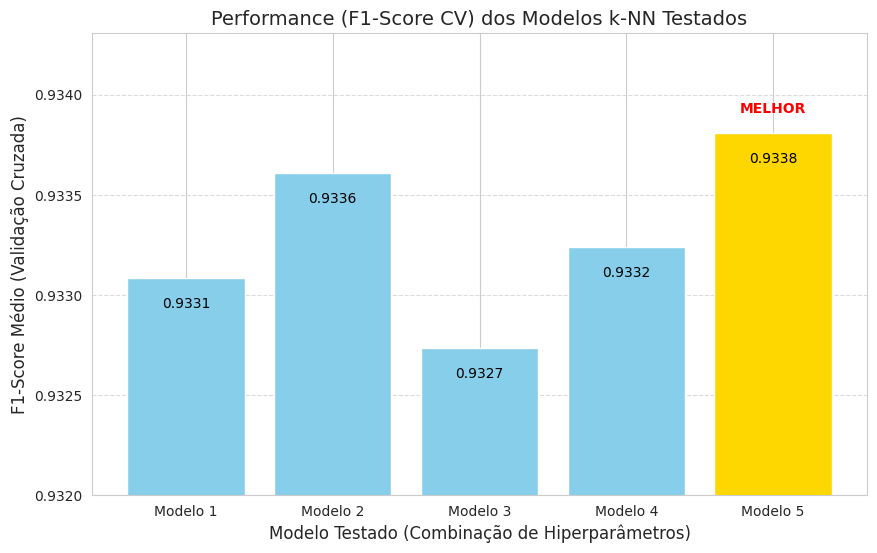

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Assumindo que as variáveis 'random_search_knn', 'scores', e 'params' estão definidas ---

# 1. Extrair Resultados Detalhados
results = random_search_knn.cv_results_
scores = results['mean_test_score']
params = results['params']

print("--- Resultados Detalhados dos 5 Modelos Testados ---")

model_labels = []
f1_scores_list = []

for i in range(len(scores)):
    f1_score_cv = scores[i]
    hiperparametros = params[i]

    param_str = ', '.join([f'{k}: {v}' for k, v in hiperparametros.items()])

    modelo_label = f"Modelo {i + 1}"
    print(f"{modelo_label}: F1-Score: {f1_score_cv:.4f} | Valores: {{{param_str}}}")

    model_labels.append(modelo_label)
    f1_scores_list.append(f1_score_cv)


# ----------------------------------------------------------------------
# 2. Gerar Gráfico de Barras com Escala Ajustada
# ----------------------------------------------------------------------

print("\n--- Gerando Gráfico de Performance com Escala Ajustada ---")

best_index = np.argmax(f1_scores_list)
colors = ['skyblue'] * len(f1_scores_list)
colors[best_index] = 'gold' # Destaca o melhor modelo

plt.figure(figsize=(10, 6))
plt.bar(model_labels, f1_scores_list, color=colors)

# Adicionar o valor do F1-Score em cima de cada barra
for i, score in enumerate(f1_scores_list):
    # Posição da anotação: um pouco abaixo do topo da barra
    plt.text(i, score - 0.00015, f'{score:.4f}', ha='center', color='black', fontsize=10)

# Adicionar a informação de "Melhor Modelo" acima da barra vencedora
plt.text(best_index, f1_scores_list[best_index] + 0.0001, 'MELHOR', ha='center', color='red', fontweight='bold')


# **Ajuste da Escala do Eixo Y AQUI**
min_score = 0.9320  # Ajustado para começar um pouco abaixo de 0.9327
max_score = max(f1_scores_list) + 0.0005 # Adiciona uma pequena margem no topo

plt.ylim(min_score, max_score)

plt.title('Performance (F1-Score CV) dos Modelos k-NN Testados', fontsize=14)
plt.xlabel('Modelo Testado (Combinação de Hiperparâmetros)', fontsize=12)
plt.ylabel('F1-Score Médio (Validação Cruzada)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()





# 5.2 Avaliação no Conjunto de Teste





In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# O melhor modelo otimizado
best_knn_model = random_search_knn.best_estimator_

# Fazer previsões no conjunto de teste
y_pred_knn = best_knn_model.predict(X_teste_selected)

print("\n--- Relatório de Classificação Final (k-NN Otimizado) ---")
print(classification_report(y_teste, y_pred_knn, target_names=['Normal (0)', 'Ataque (1)']))
print("\n--- Matriz de Confusão ---")
print(confusion_matrix(y_teste, y_pred_knn))


--- Relatório de Classificação Final (k-NN Otimizado) ---
              precision    recall  f1-score   support

  Normal (0)       0.95      0.70      0.81     37000
  Ataque (1)       0.80      0.97      0.88     45332

    accuracy                           0.85     82332
   macro avg       0.88      0.84      0.84     82332
weighted avg       0.87      0.85      0.85     82332


--- Matriz de Confusão ---
[[25848 11152]
 [ 1244 44088]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# O melhor modelo otimizado
best_knn_model = random_search_knn.best_estimator_

# 2. Obter as probabilidades para o conjunto de teste
# y_probas[:, 1] contém a probabilidade de ser Ataque (Label 1)
y_probas_knn = best_knn_model.predict_proba(X_teste_selected)
y_scores_knn = y_probas_knn[:, 1]

# 3. Ajustar o Limiar (Threshold) de Classificação.
threshold_knn = 0.90 # <--- ALtere este valor (ex: 0.6, 0.7, 0.8)

# 4. Gerar novas previsões: 1 (Ataque) se a probabilidade for >= limiar, senão 0 (Normal)
y_pred_knn_threshold = (y_scores_knn >= threshold_knn).astype(int)

# 5. Avaliar o desempenho com o novo limiar
print(f"\n--- Relatório de Classificação k-NN com Limiar = {threshold_knn} ---")
print(classification_report(y_teste, y_pred_knn_threshold, target_names=['Normal (0)', 'Ataque (1)']))

# 6. Matriz de Confusão e Cálculo de FP
cm_knn = confusion_matrix(y_teste, y_pred_knn_threshold)
print("\n--- Matriz de Confusão ---")
print(cm_knn)

# Cálculo da nova taxa de Falsos Positivos (FP)
# Suporte Normal (Total de amostras na classe 0) = 37000
falsos_positivos_knn = cm_knn[0, 1]
taxa_fp_knn = (falsos_positivos_knn / 37000) * 100

print(f"\nNúmero de Falsos Positivos (FP) com limiar {threshold_knn}: {falsos_positivos_knn}")
print(f"Nova Taxa de Falsos Positivos (FP): {taxa_fp_knn:.2f}%")
print("---------------------------------------------------------------")

# 6. Treino do modelo:
## MLPClassifier - (Baseado em Kernel) e o RandomizedSearchCV (Busca Aleatória) como técnica de HPO

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
import time
import numpy as np

# Assumindo que você tem: X_treino_selected, y_treino, X_teste_selected, y_teste

# ----------------------------------------------------------------------
# 1. Definir o Espaço de Busca de Hiperparâmetros (Distribuições)
# ----------------------------------------------------------------------

# Arquitetura (tamanho das camadas ocultas)
# Opções comuns: uma camada grande, duas camadas médias, três camadas menores.
hidden_layers = [
    (100,),               # 1 camada de 100
    (50, 50),             # 2 camadas de 50
    (100, 50),            # 2 camadas (diminuindo)
    (50, 25, 10),         # 3 camadas (diminuindo)
    (200,)                # 1 camada de 200 (mais complexa)
]

param_distributions_mlp = {
    'hidden_layer_sizes': hidden_layers,
    'activation': ['relu', 'tanh'], # Função de ativação
    'solver': ['adam'],             # O 'adam' é o otimizador mais comum e eficaz.
    'alpha': [0.0001, 0.001, 0.01], # Regularização L2 para evitar overfitting
    'learning_rate': ['constant', 'adaptive'], # Como a taxa de aprendizado deve se comportar
    'max_iter': [300]               # Número máximo de épocas (pode precisar ser ajustado)
}

# ----------------------------------------------------------------------
# 2. Configurar e Executar o Randomized Search
# ----------------------------------------------------------------------
f1_scorer = make_scorer(f1_score)
mlp = MLPClassifier(random_state=42, early_stopping=True) # early_stopping=True para evitar perda de tempo

# Configurar o RandomizedSearchCV
# n_iter=10: Testar 10 combinações aleatórias.
# cv=3: Reduzir a validação cruzada para 3 dobras para economizar tempo.
random_search_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_distributions_mlp,
    n_iter=10,
    scoring=f1_scorer,
    cv=3,                      # Redução do CV para acelerar
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Iniciando Randomized Search para MLPClassifier (Rede Neural)...")
start_time = time.time()

# Ajustar nos dados de treinamento
random_search_mlp.fit(X_treino_selected, y_treino)

end_time = time.time()
print(f"Randomized Search para MLPClassifier concluído em {end_time - start_time:.2f} segundos.")

# ----------------------------------------------------------------------
# 3. Exibir os Melhores Resultados
# ----------------------------------------------------------------------
print("\n--- Resultados da Otimização MLPClassifier ---")
print(f"Melhores Hiperparâmetros: {random_search_mlp.best_params_}")
print(f"Melhor F1-Score (média CV): {random_search_mlp.best_score_:.4f}")

best_mlp_model = random_search_mlp.best_estimator_

Iniciando Randomized Search para MLPClassifier (Rede Neural)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Randomized Search para MLPClassifier concluído em 1505.30 segundos.

--- Resultados da Otimização MLPClassifier ---
Melhores Hiperparâmetros: {'solver': 'adam', 'max_iter': 300, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 25, 10), 'alpha': 0.0001, 'activation': 'tanh'}
Melhor F1-Score (média CV): 0.9268


# 6.1 Opcional: Analise detalhada dos modelos treinados

--- Resultados Detalhados dos 10 Modelos MLP Testados ---
Modelo 1: F1-Score: 0.9241 | Valores: {activation: relu, alpha: 0.0001, hidden_layer_sizes: (100,), learning_rate: constant, max_iter: 300, solver: adam}
Modelo 2: F1-Score: 0.9258 | Valores: {activation: relu, alpha: 0.0001, hidden_layer_sizes: (100, 50), learning_rate: adaptive, max_iter: 300, solver: adam}
Modelo 3: F1-Score: 0.9268 | Valores: {activation: tanh, alpha: 0.0001, hidden_layer_sizes: (50, 25, 10), learning_rate: constant, max_iter: 300, solver: adam}
Modelo 4: F1-Score: 0.9238 | Valores: {activation: tanh, alpha: 0.001, hidden_layer_sizes: (100, 50), learning_rate: adaptive, max_iter: 300, solver: adam}
Modelo 5: F1-Score: 0.9238 | Valores: {activation: relu, alpha: 0.001, hidden_layer_sizes: (50, 50), learning_rate: adaptive, max_iter: 300, solver: adam}
Modelo 6: F1-Score: 0.9242 | Valores: {activation: tanh, alpha: 0.01, hidden_layer_sizes: (100, 50), learning_rate: constant, max_iter: 300, solver: adam}
Model

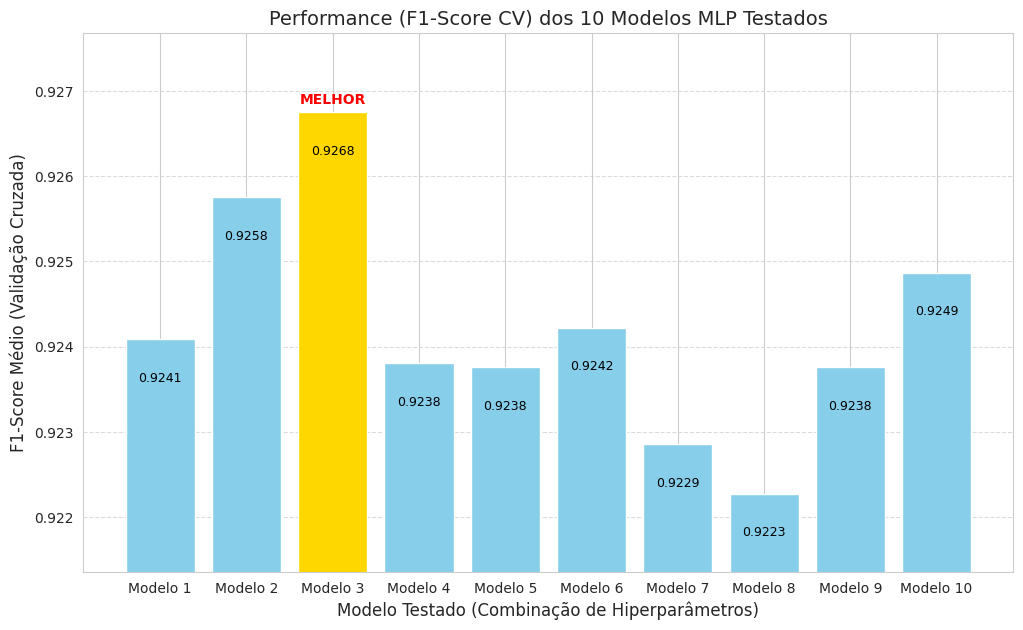


Confirmação: O melhor modelo (destacado em dourado) é o Modelo 3 com F1-Score de 0.9268.
Hiperparâmetros Vencedores: {'solver': 'adam', 'max_iter': 300, 'learning_rate': 'constant', 'hidden_layer_sizes': (50, 25, 10), 'alpha': 0.0001, 'activation': 'tanh'}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict # Usado para garantir a ordem dos parâmetros na impressão

# ----------------------------------------------------------------------
# 1. Extrair Resultados Detalhados do Randomized Search
# ----------------------------------------------------------------------

# O objeto 'cv_results_' armazena todos os resultados
results = random_search_mlp.cv_results_

# Selecionar os resultados dos 10 modelos testados (n_iter=10)
scores = results['mean_test_score']
params = results['params']

print("--- Resultados Detalhados dos 10 Modelos MLP Testados ---")

# Criar listas para o gráfico
model_labels = []
f1_scores_list = []

# Iterar sobre os 10 modelos (0 a 9, pois n_iter=10)
for i in range(len(scores)):
    f1_score_cv = scores[i]
    hiperparametros = params[i]

    # Formatação dos hiperparâmetros para exibição de forma organizada:
    # 1. Converter a tupla de hidden_layer_sizes para string
    # 2. Criar a string de parâmetros

    # Cria um OrderedDict para garantir que os parâmetros saiam na mesma ordem
    ordered_params = OrderedDict(sorted(hiperparametros.items()))

    param_list = []
    for k, v in ordered_params.items():
        if k == 'hidden_layer_sizes':
            # Formata a tupla como string (50, 25, 10)
            param_list.append(f'{k}: {str(v)}')
        else:
            param_list.append(f'{k}: {v}')

    param_str = ', '.join(param_list)

    # Impressão no formato solicitado
    modelo_label = f"Modelo {i + 1}"
    print(f"{modelo_label}: F1-Score: {f1_score_cv:.4f} | Valores: {{{param_str}}}")

    # Armazenar para o gráfico
    model_labels.append(modelo_label)
    f1_scores_list.append(f1_score_cv)


# ----------------------------------------------------------------------
# 2. Gerar Gráfico de Barras (F1-Score vs. Modelo)
# ----------------------------------------------------------------------

print("\n--- Gerando Gráfico de Performance (MLPClassifier) ---")

# Encontrar o índice do melhor modelo para destacar no gráfico
best_index = np.argmax(f1_scores_list)
colors = ['skyblue'] * len(f1_scores_list)
colors[best_index] = 'gold' # Destaca o melhor modelo

plt.figure(figsize=(12, 7))
plt.bar(model_labels, f1_scores_list, color=colors)

# Adicionar o valor do F1-Score em cima de cada barra
for i, score in enumerate(f1_scores_list):
    plt.text(i, score - 0.0005, f'{score:.4f}', ha='center', color='black', fontsize=9)

# Adicionar a informação de "Melhor Modelo" acima da barra vencedora
plt.text(best_index, f1_scores_list[best_index] + 0.0001, 'MELHOR', ha='center', color='red', fontweight='bold')

# Ajuste da Escala do Eixo Y (Focando na área de variação)
min_score = min(f1_scores_list) * 0.999
max_score = max(f1_scores_list) * 1.001
# Definindo um valor de corte razoável (ex: 0.9200) para começar o eixo
min_y = max(min_score, 0.9200)

plt.ylim(min_y, max_score)

plt.title('Performance (F1-Score CV) dos 10 Modelos MLP Testados', fontsize=14)
plt.xlabel('Modelo Testado (Combinação de Hiperparâmetros)', fontsize=12)
plt.ylabel('F1-Score Médio (Validação Cruzada)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

best_score = f1_scores_list[best_index]
best_params = params[best_index]
print(f"\nConfirmação: O melhor modelo (destacado em dourado) é o Modelo {best_index + 1} com F1-Score de {best_score:.4f}.")
print(f"Hiperparâmetros Vencedores: {best_params}")

# 6.2 Avaliação no Conjunto de Teste

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# O melhor modelo otimizado
best_mlp_model = random_search_mlp.best_estimator_

# Fazer previsões no conjunto de teste
y_pred_mlp = best_mlp_model.predict(X_teste_selected)

print("\n--- Relatório de Classificação Final (MLPClassifier Otimizado) ---")
print(classification_report(y_teste, y_pred_mlp, target_names=['Normal (0)', 'Ataque (1)']))
print("\n--- Matriz de Confusão ---")
print(confusion_matrix(y_teste, y_pred_mlp))


--- Relatório de Classificação Final (MLPClassifier Otimizado) ---
              precision    recall  f1-score   support

  Normal (0)       0.98      0.71      0.82     37000
  Ataque (1)       0.80      0.99      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.89      0.85      0.85     82332
weighted avg       0.88      0.86      0.86     82332


--- Matriz de Confusão ---
[[26143 10857]
 [  662 44670]]


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# O melhor modelo otimizado (MLPClassifier)
best_mlp_model = random_search_mlp.best_estimator_

# 1. Obter as probabilidades para o conjunto de teste
# y_probas[:, 1] contém a probabilidade de ser Ataque (Label 1)
y_probas = best_mlp_model.predict_proba(X_teste_selected)
y_scores = y_probas[:, 1]

# 2. Ajustar o Limiar (Threshold) de Classificação. 1 (Ataque) se a probabilidade for >= threshold, senão 0 (Normal)
threshold = 0.70 # <--- ALtere este valor (ex: 0.6, 0.7, 0.8)

# 3. Gerar novas previsões:
y_pred_threshold = (y_scores >= threshold).astype(int)

# 4. Avaliar o desempenho com o novo limiar
print(f"\n--- Relatório de Classificação MLP com Limiar = {threshold} ---")
print(classification_report(y_teste, y_pred_threshold, target_names=['Normal (0)', 'Ataque (1)']))

# 5. Matriz de Confusão e Cálculo de FP
cm = confusion_matrix(y_teste, y_pred_threshold)
print("\n--- Matriz de Confusão ---")
print(cm)

falsos_positivos = cm[0, 1]
taxa_fp = (falsos_positivos / 37000) * 100

print(f"\nNúmero de Falsos Positivos (FP) com limiar {threshold}: {falsos_positivos}")
print(f"Nova Taxa de Falsos Positivos (FP): {taxa_fp:.2f}%")
print("---------------------------------------------------------------")


--- Relatório de Classificação MLP com Limiar = 0.7 ---
              precision    recall  f1-score   support

  Normal (0)       0.94      0.83      0.88     37000
  Ataque (1)       0.87      0.96      0.91     45332

    accuracy                           0.90     82332
   macro avg       0.91      0.89      0.90     82332
weighted avg       0.90      0.90      0.90     82332


--- Matriz de Confusão ---
[[30632  6368]
 [ 1903 43429]]

Número de Falsos Positivos (FP) com limiar 0.7: 6368
Nova Taxa de Falsos Positivos (FP): 17.21%
---------------------------------------------------------------


# 7. Treino do modelo:
## SVM (Baseado em Kernel) e o RandomizedSearchCV (Busca Aleatória) como técnica de HPO

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
import time
import numpy as np
from scipy.stats import reciprocal

# ----------------------------------------------------------------------
# 1. Definir o Espaço de Busca de Hiperparâmetros
# ----------------------------------------------------------------------

# O SVM é muito sensível, então os parâmetros C e gamma são ajustados em escala logarítmica.
param_distributions_svm = {
    # C (Regularização): penalidade para erros. Quanto maior, menor a margem.
    # Usamos uma distribuição logarítmica para cobrir ordens de magnitude.
    # Distriuições de C entre 0.1 e 1000
    'C': reciprocal(0.1, 1000),

    # gamma (Kernel RBF): define o raio de influência das amostras de treino.
    # Distrições de gamma entre 0.0001 e 10
    'gamma': reciprocal(0.0001, 10),

    # Kernel: RBF é geralmente o mais eficaz para problemas não lineares como IDS.
    'kernel': ['rbf']
}

# ----------------------------------------------------------------------
# 2. Configurar e Executar o Randomized Search
# ----------------------------------------------------------------------
f1_scorer = make_scorer(f1_score)

# Reduzimos o max_iter para o mínimo (ex: 5) e o CV para 3.
# O SVM é quadraticamente (N^2) mais lento.
random_search_svm = RandomizedSearchCV(
    estimator=SVC(random_state=42),
    param_distributions=param_distributions_svm,
    n_iter=5, # Apenas 5 iterações para evitar tempo excessivo.
    scoring=f1_scorer,
    cv=3,                      # Apenas 3 dobras.
    n_jobs=-1,
    random_state=42,
    verbose=2
)

print("Iniciando Randomized Search para SVM (Support Vector Machine)...")
start_time = time.time()

# Ajustar nos dados de treinamento
random_search_svm.fit(X_treino_selected, y_treino)

end_time = time.time()
print(f"Randomized Search para SVM concluído em {end_time - start_time:.2f} segundos.")

# ----------------------------------------------------------------------
# 3. Exibir os Melhores Resultados
# ----------------------------------------------------------------------
print("\n--- Resultados da Otimização SVM ---")
print(f"Melhores Hiperparâmetros: {random_search_svm.best_params_}")
print(f"Melhor F1-Score (média CV): {random_search_svm.best_score_:.4f}")

best_svm_model = random_search_svm.best_estimator_

Iniciando Randomized Search para SVM (Support Vector Machine)...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Randomized Search para SVM concluído em 31328.65 segundos.

--- Resultados da Otimização SVM ---
Melhores Hiperparâmetros: {'C': np.float64(0.4207988669606635), 'gamma': np.float64(0.000602521573620386), 'kernel': 'rbf'}
Melhor F1-Score (média CV): 0.9490


# 7.1 Opcional: Analise detalhada dos modelos treinados


--- Resultados Detalhados dos 5 Modelos SVM Testados ---
Modelo 1: F1-Score: 0.9112 | Valores: {C: 3.148912, gamma: 5.669850, kernel: rbf}
Modelo 2: F1-Score: 0.9243 | Valores: {C: 84.718014, gamma: 0.098467, kernel: rbf}
Modelo 3: F1-Score: 0.9490 | Valores: {C: 0.420799, gamma: 0.000603, kernel: rbf}
Modelo 4: F1-Score: 0.9192 | Valores: {C: 0.170740, gamma: 2.142302, kernel: rbf}
Modelo 5: F1-Score: 0.9224 | Valores: {C: 25.378155, gamma: 0.347027, kernel: rbf}

--- Gerando Gráfico de Performance (SVM) ---


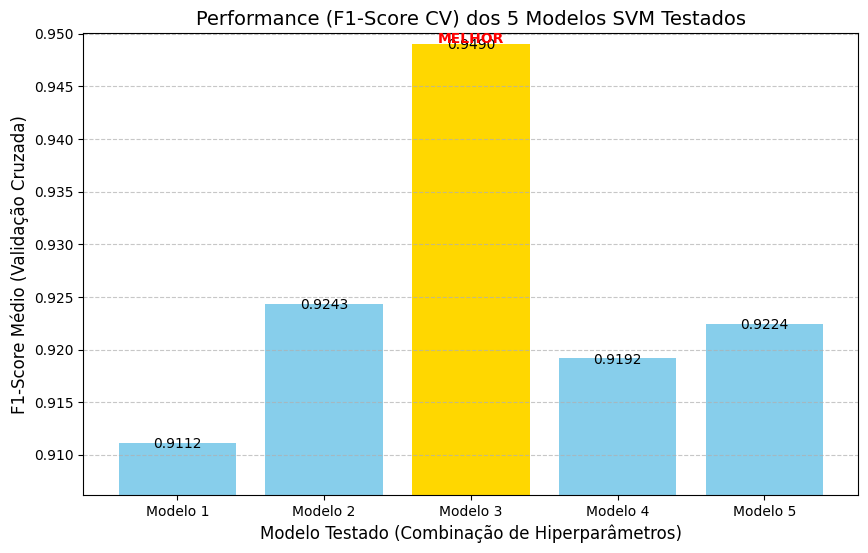


Confirmação: O melhor modelo (destacado em dourado) é o Modelo 3 com F1-Score de 0.9490.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# O objeto 'cv_results_' armazena todos os resultados
results = random_search_svm.cv_results_

# Selecionar os resultados dos 5 modelos testados (n_iter=5)
scores = results['mean_test_score']
params = results['params']

print("--- Resultados Detalhados dos 5 Modelos SVM Testados ---")

# Criar listas para o gráfico
model_labels = []
f1_scores_list = []

for i in range(len(scores)):
    f1_score_cv = scores[i]
    hiperparametros = params[i]

    # Ordenar e formatar os parâmetros
    ordered_params = OrderedDict(sorted(hiperparametros.items()))
    param_str = ', '.join([f'{k}: {v:.6f}' if isinstance(v, float) else f'{k}: {v}' for k, v in ordered_params.items()])

    # Impressão no formato solicitado
    modelo_label = f"Modelo {i + 1}"
    print(f"{modelo_label}: F1-Score: {f1_score_cv:.4f} | Valores: {{{param_str}}}")

    # Armazenar para o gráfico
    model_labels.append(modelo_label)
    f1_scores_list.append(f1_score_cv)


# ----------------------------------------------------------------------
# 2. Gerar Gráfico de Barras (F1-Score vs. Modelo)
# ----------------------------------------------------------------------

print("\n--- Gerando Gráfico de Performance (SVM) ---")

best_index = np.argmax(f1_scores_list)
colors = ['skyblue'] * len(f1_scores_list)
colors[best_index] = 'gold' # Destaca o melhor modelo

plt.figure(figsize=(10, 6))
plt.bar(model_labels, f1_scores_list, color=colors)

# Adicionar o valor do F1-Score em cima de cada barra
for i, score in enumerate(f1_scores_list):
    plt.text(i, score - 0.0005, f'{score:.4f}', ha='center', color='black', fontsize=10)

# Adicionar a informação de "Melhor Modelo" acima da barra vencedora
plt.text(best_index, f1_scores_list[best_index] + 0.0001, 'MELHOR', ha='center', color='red', fontweight='bold')

# Ajuste da Escala do Eixo Y
min_y = min(f1_scores_list) - 0.005 # Ajuste para visualizar melhor a variação
max_y = max(f1_scores_list) + 0.001

plt.ylim(min_y, max_y)

plt.title('Performance (F1-Score CV) dos 5 Modelos SVM Testados', fontsize=14)
plt.xlabel('Modelo Testado (Combinação de Hiperparâmetros)', fontsize=12)
plt.ylabel('F1-Score Médio (Validação Cruzada)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

best_score = f1_scores_list[best_index]
best_params = params[best_index]
print(f"\nConfirmação: O melhor modelo (destacado em dourado) é o Modelo {best_index + 1} com F1-Score de {best_score:.4f}.")

# 7.2 Avaliação no Conjunto de Teste

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

best_svm_model = random_search_svm.best_estimator_

y_pred_svm = best_svm_model.predict(X_teste_selected)

print("\n--- Relatório de Classificação Final (SVM Otimizado) ---")
print(classification_report(y_teste, y_pred_svm, target_names=['Normal (0)', 'Ataque (1)']))
print("\n--- Matriz de Confusão ---")
print(confusion_matrix(y_teste, y_pred_svm))


--- Relatório de Classificação Final (SVM Otimizado) ---
              precision    recall  f1-score   support

  Normal (0)       1.00      0.58      0.73     37000
  Ataque (1)       0.74      1.00      0.85     45332

    accuracy                           0.81     82332
   macro avg       0.87      0.79      0.79     82332
weighted avg       0.86      0.81      0.80     82332


--- Matriz de Confusão ---
[[21425 15575]
 [   45 45287]]
